In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

train_data1 = pd.read_csv('./BATADAL_dataset03.csv', sep = ',')
train_data2 = pd.read_csv('./BATADAL_dataset04.csv', sep = ', ')
test_data = pd.read_csv('./BATADAL_test_dataset.csv', sep = ',')

print("Shape non-attack: ", train_data1.shape)
print("Shape train: ", train_data2.shape)
print("Shape test: ", test_data.shape)

# All numeric values except from the first (datetime)
# print(train_data1.columns.values)

# convert DATETIME to timestamp
train_data = pd.concat([train_data1, train_data2], axis=0, ignore_index=True)
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], infer_datetime_format=True)
train_data['Year'] = train_data['DATETIME'].apply(lambda x: x.year)
train_data['Month'] = train_data['DATETIME'].apply(lambda x: x.month)
train_data['Day'] = train_data['DATETIME'].apply(lambda x: x.day)
train_data['Hour'] = train_data['DATETIME'].apply(lambda x: x.hour)

test_data['DATETIME'] = pd.to_datetime(test_data['DATETIME'], infer_datetime_format=True)
test_data['Year'] = test_data['DATETIME'].apply(lambda x: x.year)
test_data['Month'] = test_data['DATETIME'].apply(lambda x: x.month)
test_data['Day'] = test_data['DATETIME'].apply(lambda x: x.day)
test_data['Hour'] = test_data['DATETIME'].apply(lambda x: x.hour)

# Final versions of training and test dataframes
y = train_data['ATT_FLAG'].values
train_data = train_data.drop(columns=['DATETIME', 'ATT_FLAG'])
test_data = test_data.drop(columns=['DATETIME'])

# Training and test dataset
X = train_data.values
X_test = test_data.values

# drop columns with 0 variance as they can be of no use
index = np.std(X, axis=0) != 0
X = X[:, index]

# separate the two training datasets again
X1 = X[:8761]
X2 = X[8761:]
y1 = y[:8761]
y2 = y[8761:]

# NaNs
print("Number of NaN values in training dataset: ", np.sum(pd.isna(train_data).values))
print("Number of NaN values in test dataset: ", np.sum(pd.isna(train_data).values))


print("Training dataset shape: ", X.shape)
print("Number of attacks: ", np.sum(y==1))

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Shape non-attack:  (8761, 45)
Shape train:  (4177, 45)
Shape test:  (2089, 44)
Number of NaN values in training dataset:  0
Number of NaN values in test dataset:  0
Training dataset shape:  (12938, 40)
Number of attacks:  219


## Correlation matrix

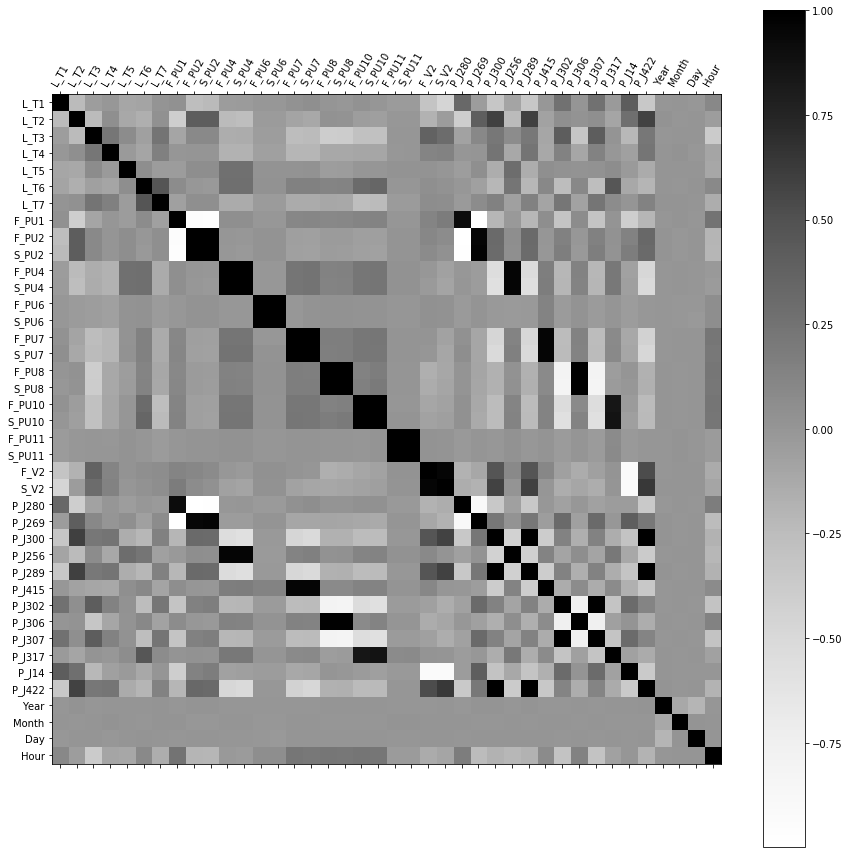

In [4]:
# Extract columns names corresponding to features with non-zero variance
labels = train_data.columns[index]

plt.figure(figsize = (15,15))
corr_matrix = np.corrcoef(X1, rowvar=False)
plt.matshow(corr_matrix, fignum=1, cmap='Greys')
plt.xticks(range(len(labels)), labels, rotation=60)
plt.yticks(range(len(labels)), labels)
plt.colorbar()

## Discrete Methods

### Piecewise Aggregate Approximation

In [3]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X1_scaled = ss.fit_transform(X1)

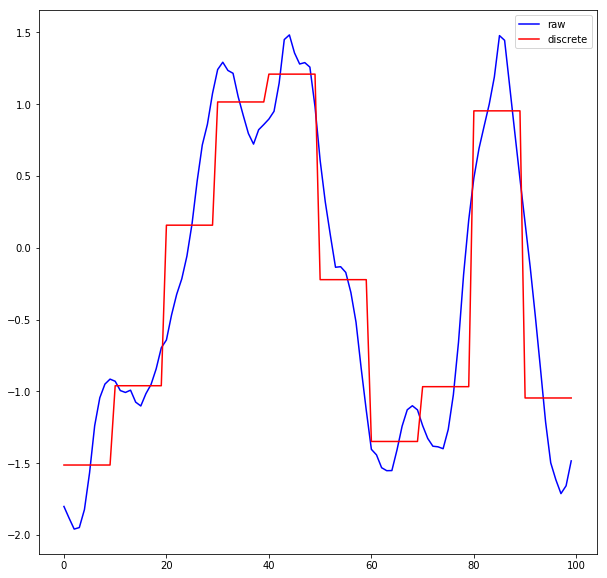

In [4]:
from tslearn.piecewise import PiecewiseAggregateApproximation

raw_data = X1_scaled[:100, 0]

n_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(raw_data))

plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(paa_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

#### Sybmolic Aggregate Approximation

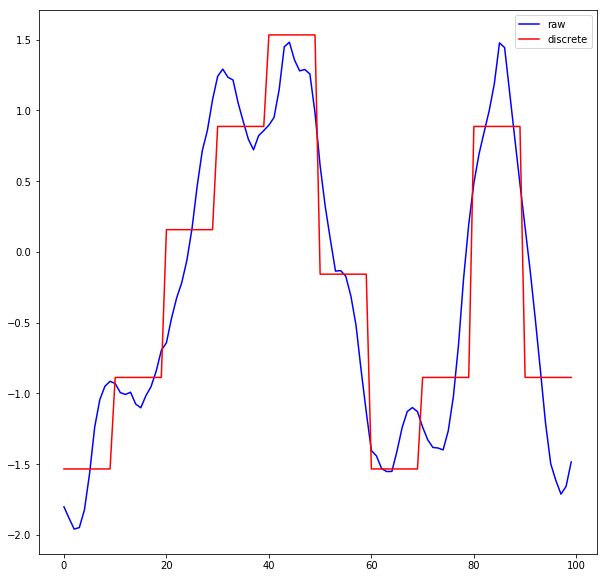

In [5]:
from tslearn.piecewise import SymbolicAggregateApproximation

n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset = sax.fit_transform(raw_data)
sax_dataset_inv = sax.inverse_transform(sax_dataset)

plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(sax_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

In [222]:
window_size = np.arange(1, 16, dtype=int)
vocab_size = np.arange(3, 12, dtype=int)
paa_segments = np.arange(2, 9, dtype=int)
L = np.array([100,200, 500])

signal = X1[:, 0]
test_signal = X2[:, 0]

TP = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)), dtype=int)
FP = np.zeros_like(TP)
for w in range(len(window_size)):
    for p in range(len(paa_segments)):
        for v in range(len(vocab_size)):
            for l in range(len(L)):
                train_sax=sax_via_window(signal, window_size[w], paa_segments[p], vocab_size[v],
                   nr_strategy='none', z_threshold=0.01)
                test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                             nr_strategy='none')

                train_probs = extract_ngram_probs(train_sax)
                train_prof = extract_train_prof(train_probs, thres=L[l])
                alarm_regions = extract_alarm_regions(test_sax, train_prof)
                TP[w,p,v,l], FP[w,p,v,l], intersect = evaluate(np.where(y2==1), alarm_regions)
                print(TP[w,p,v,l], FP[w,p,v,l])
            
            

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0


KeyboardInterrupt: 

In [219]:
import operator

def extract_ngram_probs(sax):
    
    ngrams = list(sax.keys())
    
    l = list(sax.values())
    flat = [item for sublist in l for item in sublist]
    tot = len(flat)
    
    ngram_probs = {}
    for i in ngrams:
        ngram_probs[i] = len(sax[i])/tot
    return ngram_probs

def extract_train_prof(train_probs, thres=None):
    train_ngrams = list(train_probs.keys())
    
    train_prof = []
    if thres == 1:
        train_prof = sorted(train_probs.keys(), key=operator.itemgetter(1), reverse=True)
    elif thres > 1:
        sorted_probs = sorted(train_probs.keys(), key=operator.itemgetter(1), reverse=True)
        train_prof = sorted_probs[:thres]
    elif thres >0 and thres < 1: 
        for i in train_ngrams:
            if train_probs[i] >= thres:
                train_prof.append(i)
    else:
        print("Give correct threshold")

    return train_prof

def extract_alarm_regions(test_sax, train_prof):
    test_ngrams = list(test_sax.keys())
    alarm_ngrams = [ngram for ngram in test_ngrams if ngram not in train_prof]
    alarm_regions = []
    for i in alarm_ngrams:
        alarm_regions.append(test_sax[i])
    alarm_regions = [x for sublist in alarm_regions for x in sublist]
    return alarm_regions

def evaluate(y, alarm_regions):
    intersect = np.isin(alarm_regions, np.where(y2==1))
    TP = np.sum(intersect)
    FP = np.sum(intersect==0)
    return TP, FP, intersect

def plot(y, alarm_regions, intersect):
    plt.figure(figsize=(20,10))
    ytrue = np.array(y, copy=True)
    ytrue[ytrue==-999] = 0
    ypred = np.zeros_like(y2)
    ypred[alarm_regions] = 1
    
    ind = np.array(alarm_regions)[intersect]
    Y = np.zeros_like(ytrue)
    Y[ind] = 1
    plt.fill(Y, facecolor='r', alpha=0.5)
    
    plt.plot(ytrue, color = 'r', label='actual')
    plt.plot(ypred, color = 'k', label='predicted', alpha=0.4)
    plt.legend()


In [237]:
from saxpy.sax import sax_via_window

train_sax=sax_via_window(X1[:, 0], 51, 8, alphabet_size=3,
               nr_strategy='none', z_threshold=0.01)
test_sax = sax_via_window(X2[:,0], 51, 8, alphabet_size=3,
                         nr_strategy='none')

In [238]:
train_probs = extract_ngram_probs(train_sax)
print(len(train_probs))
train_prof = extract_train_prof(train_probs, thres=1)
alarm_regions = extract_alarm_regions(test_sax, train_prof)
TP, FP, intersect = evaluate(np.where(y2==1), alarm_regions)

print(TP, FP)

425
45 119


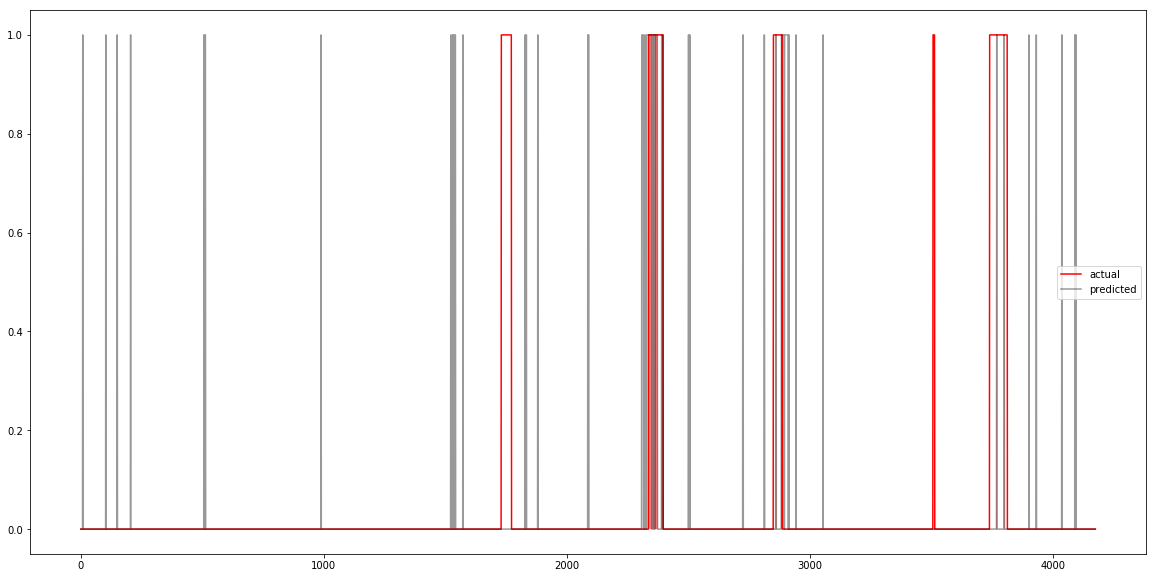

In [230]:
plot(y2, alarm_regions, intersect)

In [198]:
np.array(alarm_regions)[intersect]

array([2883, 2884, 2885, 2350, 2356, 2337, 2338, 2339, 2340, 2341, 2342,
       2343, 2344, 2345, 2346, 2347, 2348, 2349, 2353, 2354, 2355, 2357,
       2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2369, 2370,
       2371, 2876, 2877, 2881, 2882, 2886, 2887, 3748])